In [1]:
import numpy as np
import pandas as pd
from functools import partial
import argmaxml
from google_trans_new import google_translator
import sys
import seaborn as sns



import lightgbm as lgb


Add your full name, email, and phone number.

We will contact you with a free ticket in case you win

In [2]:
# Fill in your full name, email and phone number
my_submit = partial(argmaxml.submit, "Oded", "oded@gmail.com", "050")

## Reading the data

In [3]:
df = pd.read_csv("jul_train.csv")
test_users = df.user_id.unique()

In [4]:
df.head()

,user_id,segment_id,order_id,quantity,product_id,category_id,category_name,order_year,order_month,order_day
0,2832,4,26369,4,1906,1,תינוקות וילדים,2018,10,28
1,2832,4,26369,2,3029,1,תינוקות וילדים,2018,10,28
2,2230,4,21747,2,3298,1,תינוקות וילדים,2018,10,31
3,2230,4,21747,1,1815,1,תינוקות וילדים,2018,10,31
4,2908,4,33134,1,3666,1,תינוקות וילדים,2018,10,31


In [5]:
# sample_df = df.sample(10000)

In [6]:
# functions:
MAX_PRODUCT = 10000

def initial_edit(df, sample_size=None):
    cols=["order_year","order_month","order_day"]
    if(sample_size):
        sample_df = df.sample(sample_size)
    else:
        sample_df = df.copy()
        
    

    sample_df['date'] = sample_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    sample_df["date"] = sample_df["date"].apply(pd.to_datetime)
    sample_df = sample_df.sort_values(    ['user_id', 'order_id','date'], ascending=False  )
    if (any(sample_df.duplicated(subset=['user_id', 'order_id', 'product_id']))):
        print('duplicate order_id-product_id-user in initial data set')
        print('drop duplicates [user_id, order_id, product_id]')
        sample_df = sample_df.drop_duplicates(['user_id', 'order_id', 'product_id'])

    return sample_df

def create_product_order_products_users_orders_dfs(df):
    product_order = df.copy()
 
    product_order['order_product'] = product_order.product_id + product_order.order_id * MAX_PRODUCT
    product_order.set_index(['order_product'], inplace=True, drop=False)
    print('maximal product_id {}, should be lower than {}'.format(product_order.product_id.max(), MAX_PRODUCT))
    
    
    
    products = pd.DataFrame()
    products = sample_df.groupby('product_id').agg({'quantity': 'mean', 'category_id':'median', 'order_id':pd.Series.nunique , 'user_id': pd.Series.nunique}) 
    products = products.rename(columns={'order_id': 'total_orders_for_this_prod', 'user_id': 'total_users_for_this_prod'})
    
    orders = df.drop_duplicates(subset = ["user_id", 'order_id'])
    orders = orders.sort_values(['user_id','date'], ascending=False  )
    orders.assign(timediff=orders.groupby(['user_id']).date.diff(-1).dt.days.fillna(0))

    orders['days_since_prior_order']=orders.groupby(['user_id']).date.diff(-1).dt.days.fillna(0)
    orders.set_index('order_id', inplace=True, drop=False)
    orders['total_items_order'] = sample_df.groupby('order_id').size().astype(np.int16) 
    orders['total_quantity_order'] = sample_df.groupby('order_id')['quantity'].sum().astype(np.int16) 
    
    
    users = pd.DataFrame()
    users['total_items'] = sample_df.groupby('user_id')['quantity'].sum().astype(np.int16)
    users['all_products'] = sample_df.groupby('user_id')['product_id'].apply(set)
    users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)
    users['total_orders'] = orders.groupby('user_id').size().astype(np.int16)
    users['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
    users['segment_id'] = sample_df.groupby('user_id').agg({"segment_id": "unique"}) 
    users['segment_id'] = users['segment_id'].apply(lambda x: x[0])
    users['average_basket'] = (users.total_items / users.total_orders).astype(np.float32)
    print('user f', users.shape)


    return product_order, products, users, orders

In [7]:
sample_df = initial_edit(df)
sample_df.head(5)

duplicate order_id-product_id-user in initial data set
drop duplicates [user_id, order_id, product_id]


,user_id,segment_id,order_id,quantity,product_id,category_id,category_name,order_year,order_month,order_day,date
80024,4414,3,32908,3,2765,2,טרי מהשוק,2019,9,25,2019-09-25
96217,4414,3,32756,1,1384,28,חטיפים וממתקים,2019,11,13,2019-11-13
128507,4414,3,32648,1,1188,2,טרי מהשוק,2020,1,27,2020-01-27
73761,4414,3,23778,2,1186,1,תינוקות וילדים,2019,9,11,2019-09-11
133605,4414,3,21957,1,1188,2,טרי מהשוק,2020,2,5,2020-02-05


In [8]:
product_order, products, users, orders = create_product_order_products_users_orders_dfs(sample_df)

maximal product_id 4449, should be lower than 10000
user f (2609, 7)


In [9]:
train_prod_order = sample_df.copy()
train_prod_order.set_index(['order_id', 'product_id'], inplace=True, drop=False)

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%5000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        # how many product as the number of repet
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train_prod_order.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_segment'] = df.user_id.map(users.segment_id)
    df['user_total_orders'] = df.user_id.map(users.total_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    df['total_items_order'] = df.order_id.map(orders.total_items_order)
    df['total_quantity_order'] = df.order_id.map(orders.total_quantity_order)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['avg_quantity_product'] = df.product_id.map(products.quantity)
    df['category_id'] = df.product_id.map(products.category_id)
    df['total_orders_for_this_prod'] = df.product_id.map(products.total_orders_for_this_prod)

    print('order_product related features')
    df['temp'] = df.order_id * MAX_PRODUCT + df.product_id
    df['quantity'] = df.temp.map(product_order.quantity).fillna(0)
    df['norm_quantity'] = (df['quantity'] / df['avg_quantity_product'])


    df.drop(['temp'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)
    

df_train, labels = features(orders, labels_given=True)



build candidate list
order row 5000
order row 10000
order row 15000
order row 20000
order row 25000
order row 30000
user related features
order related features
product related features
order_product related features
order_id                              int32
product_id                            int32
user_id                               int64
user_segment                          int64
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
total_items_order                     int16
total_quantity_order                  int16
days_since_prior_order              float64
days_since_ratio                    float64
avg_quantity_product                float64
category_id                         float64
total_orders_for_this_prod            int64
quantity                            float64
norm_quantity                      

In [14]:
df_train.head(33)

,order_id,product_id,user_id,user_segment,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,total_items_order,total_quantity_order,days_since_prior_order,days_since_ratio,avg_quantity_product,category_id,total_orders_for_this_prod,quantity,norm_quantity
0,20199,1186,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.571429,1.0,7,0.0,0.00000
1,20199,4354,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.159783,37.0,1477,0.0,0.00000
2,20199,1188,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.449170,2.0,964,2.0,1.38010
3,20199,4294,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.200000,6.0,5,0.0,0.00000
4,20199,1384,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.300000,28.0,100,0.0,0.00000
5,20199,2765,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,2.185841,2.0,226,0.0,0.00000
6,20199,4112,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.218750,1.0,32,0.0,0.00000
7,20199,242,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,2.116667,1.0,60,0.0,0.00000
8,20199,980,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.034483,28.0,29,0.0,0.00000
9,20199,2581,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.095238,54.0,21,0.0,0.00000


In [13]:
labels

array([0, 0, 1, ..., 0, 0, 0], dtype=int8)

In [10]:
len(labels)

2107388

# Training time:


In [15]:
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'days_since_prior_order', 'days_since_ratio',
       'category_id', 'user_segment', 'total_items_order',
       'avg_quantity_product', 'total_orders_for_this_prod']

# user_total_orders, total_quantity_order, quantity, 'norm_quantity'
print('formating for lgb')
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['category_id', 'user_segment'])  
# del df_train

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100


formating for lgb


In [16]:
print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)
# lgb.plot_importance(bst, figsize=(9,20))
# del d_train


light GBM train :-)


/Users/oded/dev/oded/recommendation/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 149572, number of negative: 1957816
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2074
[LightGBM] [Info] Number of data points in the train set: 2107388, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070975 -> initscore=-2.571807
[LightGBM] [Info] Start training from score -2.571807


# Inference time 
### its a problems here are:
### 1. that I am running inferance on the training set
### 2. alot of users have 1-2 items (cold start), and for them I am recommenind the most populare items
### 3. I limit myself with only items that they bought, and it is not always true

In [17]:
### build candidates list for test ###


print('light GBM predict')
preds = bst.predict(df_train[f_to_use])

df_train['pred'] = preds


df_train.head(11)

light GBM predict


,order_id,product_id,user_id,user_segment,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,total_items_order,total_quantity_order,days_since_prior_order,days_since_ratio,avg_quantity_product,category_id,total_orders_for_this_prod,quantity,norm_quantity,pred
0,20199,1186,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.571429,1.0,7,0.0,0.0000,0.071435
1,20199,4354,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.159783,37.0,1477,0.0,0.0000,0.071023
2,20199,1188,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.449170,2.0,964,2.0,1.3801,0.134421
3,20199,4294,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.200000,6.0,5,0.0,0.0000,0.035632
4,20199,1384,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.300000,28.0,100,0.0,0.0000,0.065141
5,20199,2765,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,2.185841,2.0,226,0.0,0.0000,0.084665
6,20199,4112,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.218750,1.0,32,0.0,0.0000,0.062804
7,20199,242,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,2.116667,1.0,60,0.0,0.0000,0.151525
8,20199,980,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.034483,28.0,29,0.0,0.0000,0.029179
9,20199,2581,4414,3,13,31,13,11.384615,2.384615,1,2,1.0,0.087838,1.095238,54.0,21,0.0,0.0000,0.041412


In [18]:
TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

def get_updated_results(res_df, products_df):
    idx = res_df.groupby(['user_id'])['pred'].transform(max) == res_df['pred']
    results = res_df[idx]
    results = results.drop_duplicates(["user_id", "pred"])
    most_popular_product = products_df.sort_values(by=['total_users_for_this_prod'], ascending=False).head(1).index.values[0]
    print('most popular product is {}'.format(most_popular_product))
    results['recommendation'] = results.apply(lambda x: int(x['product_id']) if x['pred']>TRESHOLD and x['user_total_items']>=3 else int(most_popular_product), axis=1)
    return results
# idx = df_train.groupby(['user_id'])['pred'].transform(max) == df_train['pred']
# results = df_train[idx]
# results = results.drop_duplicates(["user_id", "pred"])

results = get_updated_results(df_train,products)
results.head()

most popular product is 3917


,order_id,product_id,user_id,user_segment,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,total_items_order,total_quantity_order,days_since_prior_order,days_since_ratio,avg_quantity_product,category_id,total_orders_for_this_prod,quantity,norm_quantity,pred,recommendation
147,11225,1384,4414,3,13,31,13,11.384615,2.384615,3,10,1.0,0.087838,1.300000,28.0,100,0.0,0.000000,0.268302,1384
439,20190,31,4412,3,18,63,19,21.333334,3.500000,4,7,7.0,0.328125,4.272331,2.0,4355,4.0,0.936257,0.385616,31
1713,9976,3917,4409,2,19,497,113,13.631579,26.157894,24,46,29.0,2.127413,5.342352,2.0,4472,5.0,0.935917,0.771892,3917
7724,36129,3917,4408,3,52,467,116,6.557693,8.980769,15,32,16.0,2.439883,5.342352,2.0,4472,0.0,0.000000,0.475980,3917
8692,10959,3277,4407,1,2,5,2,17.500000,2.500000,2,3,0.0,0.000000,1.827618,1.0,1079,2.0,1.094320,0.901957,3277


49.0


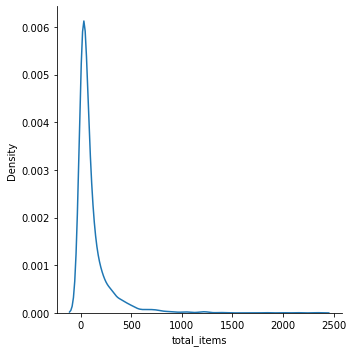

In [51]:
sns.displot(users, x="total_items", kind="kde")
print(users['total_items'].median())

## Creating a submission
### Example: Recommend the same product to everyone

In [56]:
oded_res = results.set_index('user_id').to_dict()['recommendation']

In [57]:
# Recommend product_id 2073 to everyone
submission_name = "oded_v2"
my_accuracy = my_submit(submission_name, oded_res)
print ("Submission Accuracy for {s} : {a:0.2f}%".format(a=100*my_accuracy, s=submission_name))

Submission Accuracy for oded_v2 : 21.31%


### Example: Recommend something the user already bought

In [17]:
test_submission = df.groupby("user_id")["product_id"]\
                    .apply(lambda x: list(x)[0]).to_dict()

In [18]:
submission_name = "already_bought_submission"
my_accuracy = my_submit(submission_name, test_submission)
print ("Submission Accuracy for {s} : {a:0.2f}%".format(a=100*my_accuracy, s=submission_name))

Submission Accuracy for already_bought_submission : 13.34%


## See how you compare:

Visit http://leaderboard.argmax.ml/jul or run